In [2]:
import obspy
import os, glob, re
import numpy as np
import pandas as pd
import numpy.matlib
from obspy import Trace, UTCDateTime, Stream
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
from scipy.io.wavfile import read, write
from datetime import datetime, date, timedelta
import soundfile as sf
import  scipy.signal as signal
import h5py
import warnings
warnings.filterwarnings('ignore')
def calib(data, S):
    return data / ((10)**(S/20)) 
def readmat(filename):
    arrays = {}
    f = h5py.File(filename)
    for k, v in f.items():
        key = k
        arrays[key] = np.array(v)
    #======= clean array 
    df_array = arrays[key]
    ra, ca = df_array.shape
    
    time = df_array[0, 1:ca]
    freq = df_array[1:ra, 0]
    df_array = df_array[1:ra, 1:ca]
    return time, freq, df_array

In [3]:
path = '/Volumes/home/Research/temp/PAMGuide_Batch_PSD_Abs_32000ptHannWindow_0pcOlap'
get_channel = 1

# spectrogram 
FFT_size = 1024
overlap = 0 
pref = 1

In [4]:
vmin = 60
vmax = 140
serial = '6716'
cmap = cm.jet

for hh in range(10,17):
    hh = str(hh).zfill(2)
    all_array = None
    for j, file in enumerate(sorted(glob.glob(f'{path}/*20240522_{hh}????_*.mat'))):
        time, freq, df_array = readmat(file)
        day = file.rsplit('_')[-5][-2:]

        if j == 0 :
            all_array = df_array
        else:
            all_array = np.hstack((all_array,df_array))
    if all_array is not None:
        base = datetime(2024, 5, int(day), int(hh), 0, 0) + timedelta(hours=8)
        print(base)
        alldate = [base + timedelta(seconds = 0.5*x) for x in range(all_array.shape[1])]
        fig, ax = plt.subplots(1, figsize=(10, 3))
        plt.rcParams["font.family"] = "Helvetica"
        ax2 = ax.pcolormesh(alldate, np.array(freq), all_array, cmap=cmap, vmin=vmin, vmax=vmax) 
        ax.set_yscale('log')
        ax.set_ylabel('Frequency (Hz)')
        ax.set_title(f'2024-05-{base.day} {base.hour}:00:00 - {base.hour+1}:00:00')
        ax.set_ylim(100, 10**4)
        cbar = fig.colorbar(ax2, ax=ax, pad=0.02)
        cbar.set_label('\nPower Spectral Density\n (dB re 1'r'$\mu Pa^2$/Hz)', fontsize=12)
        cbar.set_ticks(range(vmin, vmax+1, 10))
        
        plt.savefig(f'../Results/spectrogram/VLA/spectrogram_{serial}_202405{base.day}_{base.hour}0000.png', dpi=200 , bbox_inches='tight' )
        plt.close()

2024-05-22 18:00:00
2024-05-22 19:00:00
2024-05-22 20:00:00
2024-05-22 21:00:00
2024-05-22 22:00:00
2024-05-22 23:00:00
2024-05-23 00:00:00


In [136]:
total_array50 = None
total_array_mean = None
for j, file in enumerate(sorted(glob.glob(f'{path}/*22??00_mat'))[1:-2]):
    
    time, freq, df_array = readmat(file)
    if time.shape[0] == 18750:
        for i in range(0, 18750, 3750):
            temp_ = df_array[:,i:i+3750]
            if total_array50 is None:
                total_array50 = np.percentile(temp_, 50, axis=1, interpolation='midpoint')
                total_array_mean = np.mean(temp_, axis=1)
            else:
                total_array50 = np.vstack((total_array50, np.percentile(temp_, 50, axis=1, interpolation='midpoint')))
                total_array_mean = np.vstack((total_array_mean, np.mean(temp_, axis=1)))
    else:
        print(file)
        total_array50 = np.vstack((total_array50,np.full((5, 512), np.nan)))
        total_array_mean = np.vstack((total_array_mean,np.full((5, 512), np.nan)))
    # if j == 0:
    #     total_array50 = np.percentile(df_array, 50, axis=1 , interpolation='midpoint')
    #     total_array_mean = np.mean(df_array, axis=1)
    # else:
    #     total_array50 = np.vstack((total_array50, np.percentile(df_array, 50, axis=1, interpolation='midpoint')))
    #     total_array_mean = np.vstack((total_array_mean, np.mean(df_array, axis=1)))
    # print(file)
print(time.shape, freq.shape)    
print(total_array50.shape)

/Volumes/home/Research/temp/PAMGuide_Batch_PSD_Abs_1024ptHannWindow_0pcOlap/HCW4242_20240523_013000_PSD_0.016sHannWindow_0PercentOverlap.mat
/Volumes/home/Research/temp/PAMGuide_Batch_PSD_Abs_1024ptHannWindow_0pcOlap/HCW4242_20240523_013351_PSD_0.016sHannWindow_0PercentOverlap.mat
(18750,) (512,)
(1640, 512)


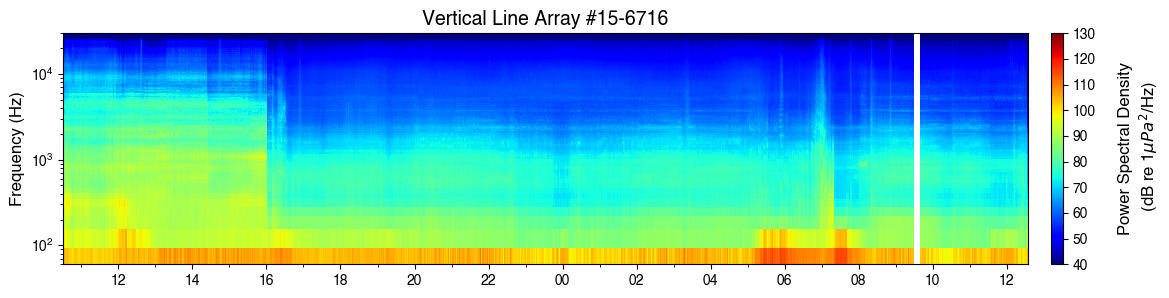

In [137]:
fig, ax = plt.subplots(1, figsize=(15, 3))
plt.rcParams["font.family"] = "Helvetica"
vmin = 40
vmax = 130
serial = '6716'
cmap = cm.jet
base = datetime(2024, 5, 22, 1, 15, 0) + timedelta(hours=8)
alldate = [base + timedelta(minutes = 1*x) for x in range(total_array50.shape[0])]
ax2 = ax.pcolormesh(alldate, np.array(freq), total_array50.T, cmap=cmap, vmin=vmin, vmax=vmax) 
ax.set_yscale('log')
ax.set_ylim(60, 30000)
ax.set_xlim(datetime(2024, 5, 22, 10, 30, 0), alldate[-1])
ax.set_ylabel('Frequency (Hz)', fontsize=12)
cbar = fig.colorbar(ax2, ax=ax, pad=0.02)
cbar.set_label('\nPower Spectral Density\n (dB re 1'r'$\mu Pa^2$/Hz)', fontsize=12)
cbar.set_ticks(range(vmin,vmax+1,10))

plt.title(f'Vertical Line Array #15-{serial}', fontsize=14)

ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))   #to get a tick every 15 minutes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))     #optional formatting 
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))   #to get a tick every 15 minutes

plt.savefig(f'../Results/spectrogram/VLA/spectrogram_{serial}.png', dpi=200 , bbox_inches='tight')
# plt.savefig(f'../Results/spectrogram/VLA/spectrogram_{serial}.pdf')

In [138]:
arr = {'time': alldate, 
       'freq': np.array(freq),
      'Mean': total_array_mean,
      '50pct': total_array50}

import pickle
pickle.dump( arr, open( f'../DataBase/PAM_pickle/VLAarray_{serial}_1min.pkl', 'wb' ) )

## dont modify

In [43]:
path = '/Volumes/ExperimentData/VerticalLineArray/2024_Keelung_port/0522-0523'
for j, file in enumerate(sorted(glob.glob(f'{path}/*20240523_03*wav')[4:5])):
    date = re.split('[_|.]', file)[-3]; time = re.split('[_|.]', file)[-2]
    rate, data = read(file)
    info = sf.info(file).extra_info
    split_result = re.split('[\n|;]', info) 
    filtered_result = [word for word in split_result if word.strip()]
    tmp = [word for word in re.split('[,|#|:|\W]',filtered_result[8]) if word.strip()]
    serial_list = [tmp[i] for i in range(5,len(tmp), 3)]
    serial_S_list = [int(s) for s in re.split('[,|:]',filtered_result[11])[1:]]; del info, split_result, filtered_result, tmp
    if get_channel is None:
        get_channel = data.shape[1]
        
    for i in range(get_channel):
        audio = np.asarray(data[:,i])
        q = np.iinfo(audio.dtype)
        abs_max = 2 ** (q.bits - 1)
        offset = q.min + abs_max
        channel_data = (audio.astype('float32') - offset) / abs_max

        
        serial = serial_list[i]
        S = serial_S_list[i]
        #channel_data = calib(channel_data, S)
        
        tr = Trace()
        tr.data = channel_data
        tr.stats.sampling_rate = rate
        tr.stats.starttime = UTCDateTime(f'{date}T{time}')
        
        f, t, P = signal.stft(tr.data, fs=tr.stats.sampling_rate, nperseg=FFT_size, window='hann',
                                    noverlap=int(overlap*FFT_size), nfft=FFT_size, 
                                    detrend='constant', boundary=None, padded=False)
        spect =10*np.log10( np.abs(P) / np.power(pref, 2)) - S
        
        if j ==0:
            total_array50 = np.median(spect, axis=1)
        else:
            total_array50 = np.vstack((total_array50, np.median(spect, axis=1)))
        

    print(file)
print('finish')

/Volumes/ExperimentData/VerticalLineArray/2024_Keelung_port/0522-0523/HCW4242_20240523_032000.wav
finish


(20, 32000)

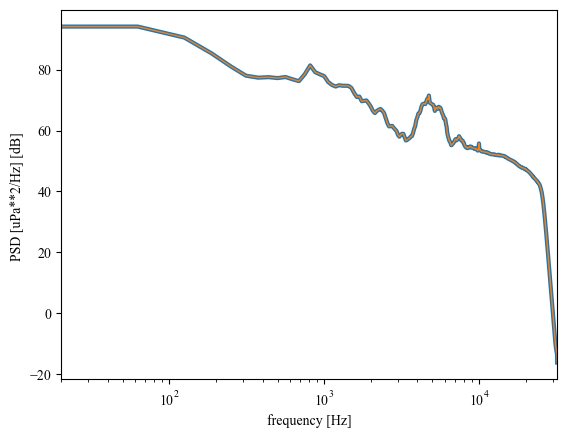

In [59]:
f, Pxx = signal.welch(calib(channel_data, S), tr.stats.sampling_rate, 
                      nperseg=FFT_size,window='hann', 
                      noverlap=0,detrend='constant',scaling='density')
Pxx = 10*np.log10(Pxx/np.power(pref,2))

f, Pxx_ = signal.welch(tr.data, tr.stats.sampling_rate, 
                      nperseg=FFT_size,window='hann', 
                      noverlap=0, detrend='constant',scaling='density')
Pxx_ = 10*np.log10(Pxx_/np.power(pref,2)) - S

plt.plot(f, Pxx, lw=3)
plt.plot(f, Pxx_, lw=1)
plt.xscale('log')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [uPa**2/Hz] [dB] ')
plt.xlim(20, 32000)
# plt.ylim(40,100)

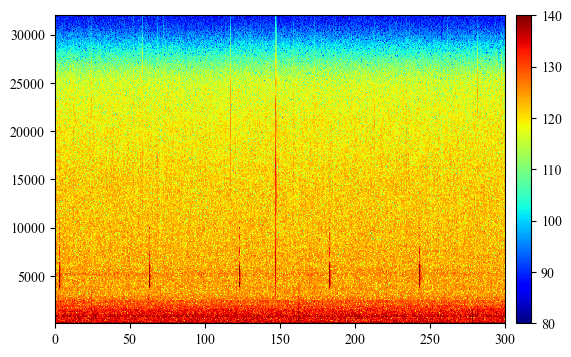

In [47]:
fig, ax = plt.subplots(1, figsize=(7, 4))
plt.rcParams["font.family"] = "Times New Roman"
vmin = 80
vmax = 140
cmap = cm.jet

ax2 = ax.pcolormesh(t, np.array(f), spect, cmap=cmap, vmin=vmin, vmax=vmax) 
# ax.set_yscale('log')
ax.set_ylim(100, 32000)
cbar = fig.colorbar(ax2, ax=ax, pad=0.02)

In [216]:
for i, qqq in enumerate(sorted(glob.glob(f'./H*.mat'))):
    print(qqq)
    #======= read array 
    arrays = {}
    f = h5py.File(qqq)
    for k, v in f.items():
        key = k
        arrays[key] = np.array(v)
        
    #======= clean array 
    df_array = arrays[key]
    ra, ca = df_array.shape
    
    time = df_array[0, 1:ca]
    freq = df_array[1:ra, 0]
    df_array = df_array[1:ra, 1:ca]
    

./HCW4242_20240522_023000_PSD_0.016sHannWindow_0PercentOverlap.mat


In [217]:
time


array([0.00000e+00, 1.60000e-02, 3.20000e-02, ..., 2.99952e+02,
       2.99968e+02, 2.99984e+02])

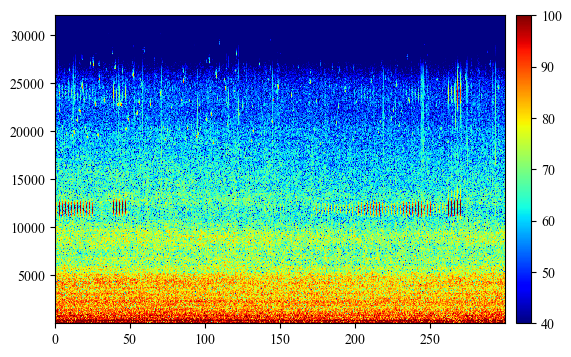

In [219]:
fig, ax = plt.subplots(1, figsize=(7, 4))
plt.rcParams["font.family"] = "Times New Roman"
vmin = 40
vmax = 100
cmap = cm.jet

ax2 = ax.pcolormesh(time, np.array(freq), df_array, cmap=cmap, vmin=vmin, vmax=vmax) 
# ax.set_yscale('log')
cbar = fig.colorbar(ax2, ax=ax, pad=0.02)